In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
item_category = pd.read_csv('item_categories.csv')
train = pd.read_csv('sales_train.csv')
test  = pd.read_csv('test.csv')

In [3]:
train['date'] = pd.to_datetime(train.date,format="%d.%m.%Y")

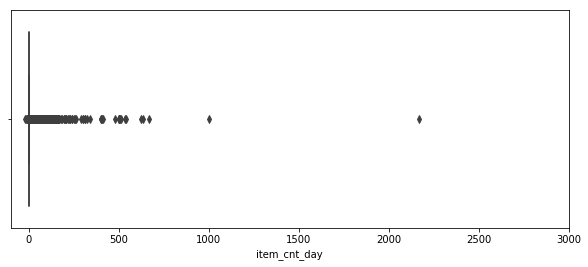

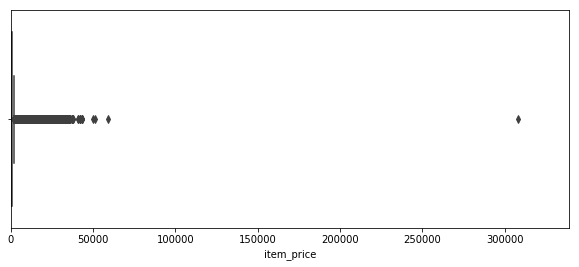

In [4]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [5]:
train = train[(train.item_price < 100000) & (train.item_price > 0)]
train = train[(train.item_cnt_day < 800) & (train.item_cnt_day >= 0)]

In [6]:
# Now we convert the raw sales data to monthly sales, broken out by item & shop
# This placeholder dataframe will be used later to create the actual training set
df = train.groupby([train.date.apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']).sum().reset_index()
df = df[['date','item_id','shop_id','item_cnt_day']]
df = df.pivot_table(index=['item_id','shop_id'], columns='date',values='item_cnt_day',fill_value=0).reset_index()
df.head()

date,item_id,shop_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,55,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Merge the monthly sales data to the test data
# This placeholder dataframe now looks similar in format to our training data
df_test = pd.merge(test, df, on=['item_id','shop_id'], how='left')
df_test = df_test.fillna(0)

# Remove the categorical data from our test data, we're not using it
df_test = df_test.drop(labels=['ID', 'shop_id', 'item_id'], axis=1)
df_test.head()

,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Now we finally create the actual training set
# Let's use the '2015-10' sales column as the target to predict
TARGET = '2015-10'
y_train = df_test[TARGET]
X_train = df_test.drop(labels=[TARGET], axis=1)

print(y_train.shape)
print(X_train.shape)
X_train.head()

(214200,)
(214200, 33)


,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,...,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# To make the training set friendly for keras, we convert it to a numpy matrix
X_train = X_train.as_matrix()
X_train = X_train.reshape((214200, 33, 1))

y_train = y_train.as_matrix()
y_train = y_train.reshape(214200, 1)

# print(y_train.shape)
# print(X_train.shape)

# X_train[:1]

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [10]:
# Lastly we create the test set by converting the test data to a numpy matrix
# We drop the first month so that our trained LSTM can output predictions beyond the known time range
X_test = df_test.drop(labels=['2013-01'],axis=1)
X_test = X_test.as_matrix()
X_test = X_test.reshape((214200, 33, 1))
print(X_test.shape)

(214200, 33, 1)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [11]:
# Create the model using the NestedLSTM class - two layers are a good starting point
# Feel free to play around with the number of nodes & other model parameters
model = Sequential()
model.add(LSTM(40, input_shape=(33, 1), dropout=0.0))
model.add(Dense(1))

# The adam optimizer works pretty well, although you might try RMSProp as well
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mean_squared_error'])
model.summary()

model.fit(X_train, y_train,batch_size=128,epochs=5)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40)                6720      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
214200/214200 [==============================] - 32s 148us/step - loss: 6.5231 - mean_squared_error: 6.5231
Epoch 2/5
214200/214200 [==============================] - 30s 142us/step - loss: 6.2208 - mean_squared_error: 6.2208
Epoch 3/5
214200/214200 [==============================] - 31s 144us/step - loss: 6.0921 - mean_squared_error: 6.0921
Epoch 4/5
214200/214200 [==============================] - 31s

In [12]:
# Get the test set predictions and clip values to the specified range
y_pred = model.predict(X_test).clip(0., 20.)

# Create the submission file and submit!
preds = pd.DataFrame(y_pred, columns=['item_cnt_month'])
preds.to_csv('submission.csv',index_label='ID')